In [62]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd
import pickle

In [66]:
def get_fdr_by_rank(pred, label):
    order = np.argsort(-pred)
    ord_label = label[order]
    fdr = np.zeros(ord_label.shape)
    negative_label = 0
    cts_negative = 0 
    max_fdr = 0
    for i, val in enumerate(ord_label):
        if val == negative_label:
            cts_negative += 1
        max_fdr = max(cts_negative / (i + 1), max_fdr)
        fdr[i] = max_fdr
    return(fdr)
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd
import pickle

class DataGenerator(torch.utils.data.Dataset):
    """
    Data generator for the m6A model. It randomly selects
    batches from the data to train the m6A model.
    """
    def __init__(self, features, labels, random_state=None):
        """
        Constructor for the data generator class, expects features
        and labels matrices.
        :param features: numpy.array, Nx15, N=number of sequences,
                                      each sequence is of length 15.
        :param labels: numpy array, one hot encoded labels for whether
                                    a sequence in features variable contains
                                    methylated A or not.
        :param random_state: numpy.random_state, allow reproducibility by selecting
                                                 a seed for random operations beforehand.
        """
        self.random_state = random_state
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        """
        Get random indices from the training data
        to form batches.
        :param idx: numpy.array, indices to retrieve, ignoring for now.
        :return: x, y: features and labels from selected indices.
        """
        i = self.random_state.choice(len(self.features))

        x = self.features[i]
        y = self.labels[i]

        x = torch.tensor(x)
        y = torch.tensor(y)

        return x, y


def m6AGenerator(data_path, random_state=None, pin_memory=True,
                 num_workers=0, batch_size=32):
    """
    This generator returns a training data generator as well as
    validation features and labels
    :param data_path: str, path where the data matrix is stored.
    :param random_state: int, seed for numpy random_state.
    :param pin_memory: bool, Makes CUDA efficient by skipping one copy
                             operation, true by default.
    :param num_workers: int, number of worker threads the generator can
                             utilize, 0 by default.
    :param batch_size: int, number of examples in each batch
    :return: X_gen: training data generator, X_val: validation features, y_val: validation labels
    """
    # initialize Random state
    random_state = np.random.RandomState(random_state)

    # Load training and validation data
    train_val_data = np.load(data_path, allow_pickle=True)

    # Get the dictionary from the containing relevant data
    train_val_data = train_val_data['save_data_dict'][()]

    # Load training and validation features and labels
    X_train = train_val_data['X_train']
    y_train = train_val_data['y_train']
    X_val = train_val_data['X_val']
    y_val = train_val_data['y_val']

    print(f"Training features shape {X_train.shape}, training labels shape: {y_train.shape}")
    print(f"Validation features shape {X_val.shape}, validation labels shape: {y_val.shape}")

    # Get the training data generator
    X_gen = DataGenerator(X_train,
                          y_train,
                          random_state=random_state)

    # Wrap it in a data loader
    X_gen = torch.utils.data.DataLoader(X_gen,
                                        pin_memory=pin_memory,
                                        num_workers=num_workers,
                                        batch_size=batch_size)

    return X_gen, (X_val, y_val)

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

# Using some sort of FDR test for the logistic regression model

In [84]:
# Loading code from Anu
X_train, (X_val, y_val) = m6AGenerator("data/m6A_train_more_large.npz", random_state=None, pin_memory=True, num_workers=2, batch_size=1000)
X_val_flat = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])

Training features shape (2532297, 7, 15), training labels shape: (2532297, 2)
Validation features shape (844099, 7, 15), validation labels shape: (844099, 2)


[0. 0. 0. ... 0. 0. 0.]


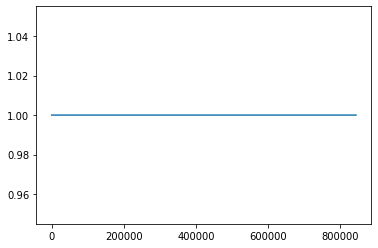

In [85]:
model = pickle.load(open("output_models/m6A_train_more_large.pickle", "rb"))

y_pred = model(torch.tensor(X_val_flat).float()).detach().numpy()
y_obs = y_val[:, 0]

order = np.argsort(-y_pred.flatten())
print(y_obs[order])

plt.plot(get_fdr_by_rank(y_pred, y_obs))

# Using some sort of FDR data for the CNN model

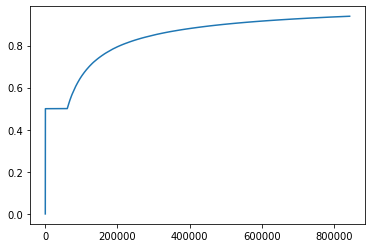

In [80]:
cnn = pickle.load(open("../anupamaj/cnn_predictions.pickle", "rb"))
y_val = cnn["y_val"][:, 0]
val_pred = cnn["val_pred"][:, 0]

order = np.argsort(-val_pred)

plt.plot(get_fdr_by_rank(val_pred, y_val))